<a href="https://colab.research.google.com/github/HikaruHotta/roadUNet/blob/master/MassDataManipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script to Crop [Massachusetts Roads Dataset](https://www.cs.toronto.edu/~vmnih/data/) and upload it to GCP Bucket

### Set Up

In [0]:
import numpy as np
import os
import cv2
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

### Define Constants and Paths

In [0]:
IMG_WIDTH, IMG_HEIGHT = 256, 256
NUM_CHANNELS = 3
NEW_IMAGE_SHAPE = (256, 256, 3)
NEW_MASK_SHAPE = (256, 256)
WRITE_ATTEMPTS = 20

root_path = '/content/drive/Shared drives/CS231n Project/mass_roads/'
cropped_path = '/content/drive/Shared drives/CS231n Project/mass_roads_cropped/'

### Crop Images and Masks

In [0]:
'''
Name: crop_save(mode)
Parameters: mode = "train", "valid", or "test"
Functionality: Crops 1500x1500x3 mass_roads satellite images into 256x256x3 and 
crops the corresponding 1500x1500 mass_roads road masks into 256x256. Images 
are in .tiff format
'''
def crop_save(mode): 
    path, dirs, files = next(os.walk(root_path + mode + '/sat/'))
    print('Cropping {} {} files.'.format(len(files), mode))
    
    counter = 0
    for file_name in tqdm(os.listdir(root_path + mode + '/sat/')):
        sat_path = root_path + mode + '/sat/' + file_name
        map_path = root_path + mode + '/map/' + file_name[:-1]
        
        sat = cv2.imread(sat_path)
        mask = cv2.imread(map_path, 0)
        
        for r in range(0, sat.shape[0], IMG_HEIGHT):
            for c in range(0, sat.shape[1], IMG_WIDTH):
                new_sat_path = cropped_path+mode+'/sat/' + str(counter) + ".tif"
                new_mask_path = cropped_path+mode+'/map/' + str(counter) + ".tif"

                new_sat = np.array(sat[r:r+IMG_HEIGHT, c:c+IMG_WIDTH, :])
                new_mask = np.array(mask[r:r+IMG_HEIGHT, c:c+IMG_WIDTH])

                if new_sat.shape == NEW_IMAGE_SHAPE and new_mask.shape == NEW_MASK_SHAPE:
                    for attempt in range(WRITE_ATTEMPTS):
                        write_new_sat = cv2.imwrite(new_sat_path, new_sat)
                        if write_new_sat: break
                        elif attempt == WRITE_ATTEMPTS - 1:
                            print("Failed to write {}. Rerun script".format(str(counter) + ".tiff"))
                        else: print("Failed to write {}. Trying again.".format(str(counter) + ".tiff"))
                    for attempt in range(WRITE_ATTEMPTS):
                        write_new_mask = cv2.imwrite(new_mask_path, new_mask)
                        if write_new_mask: break
                        elif attempt == WRITE_ATTEMPTS - 1:
                            print("Failed to write {}. Rerun script".format(str(counter) + ".tiff"))
                        else: print("Failed to write {}. Trying again.".format(str(counter) + ".tiff"))  
                    counter += 1 
    print("Generated {} cropped images from {} data".format(str(counter + 1), mode))

In [0]:
crop_save('valid')
crop_save('test')
crop_save('train')

### Plot of Original and Cropped Images + Masks



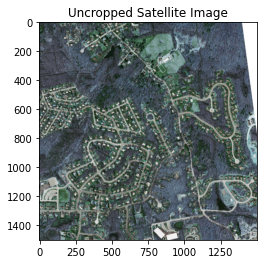

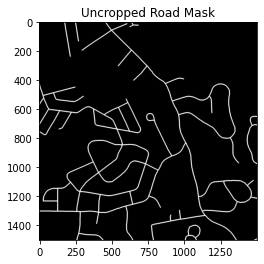

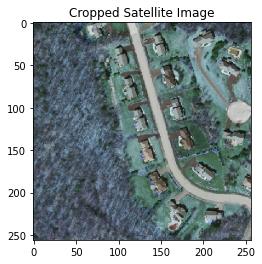

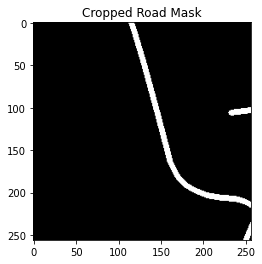

In [0]:
plt.figure(1)
plt.title('Uncropped Satellite Image')
sat_original = cv2.imread(root_path + "test" + '/sat/18478930_15.tiff')
plt.imshow(sat_original)

plt.figure(2)
plt.title('Uncropped Road Mask')
map_original = cv2.imread(root_path + "test" + '/map/18478930_15.tif')
plt.imshow(map_original)

plt.figure(3)
plt.title('Cropped Satellite Image')
sat_cropped = cv2.imread(cropped_path + "test" + '/sat/2.tif')
plt.imshow(sat_cropped)

plt.figure(4)
plt.title('Cropped Road Mask')
map_cropped = cv2.imread(cropped_path + "test" + '/map/2.tif')
plt.imshow(map_cropped)

### Transfer Cropped Files to GCP Bucket

In [0]:
from google.colab import auth
auth.authenticate_user()
project_id = #####
!gcloud config set project {project_id}
!gsutil ls
bucket_name = #####
!gsutil -m cp -r /content/drive/Shared\ drives/CS231n\ Project/mass_roads_cropped/* gs://{bucket_name}/